In [1]:
import glob

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

from tg import get_data_path, get_root_path
from tg.datasets import DATASET_FACTORY_LOOKUP

# color_palette = list(sns.color_palette("pastel").as_hex())
color_palette = list(sns.color_palette("husl", 9).as_hex())

In [2]:
dict_dataset_names = {
    "AIR_PASSENGERS": "Passageiros aéreos",
    "HOMICIDES": 'Homicídios dolosos no RJ',
    "NOISY_SINE30": "Seno ruidoso",
    "PERFECT_SINE30": "Seno perfeito",
    "RANDOM_WALK": "Caminhada aleatória"
}

dict_column_names = {
    "params.model_name": "Modelo",
    "metrics.rmse": "RMSE",
    "metrics.mae": "MAE",
    "metrics.mape": "MAPE",
    "metrics.smape": "sMAPE",
    "params.dataset_name": "Conjunto de dados"
}


In [3]:
mlflow.set_tracking_uri("file:///{}".format(get_root_path("mlruns")))
experiment = mlflow.get_experiment('0')

In [4]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs['artifact_uri'] = runs['artifact_uri'].apply(lambda x: x.replace(
    x.split('mlruns')[0], 'file///{}'.format(get_root_path(""))).replace(
        '\\', '/'))
runs.head(3)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae,metrics.mape,metrics.smape,metrics.rmse,params.model_name,params.n_train_points,params.params,params.dataset_name,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.git.commit
0,27fdc37b5e0b4bacb15615010bc35046,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-10-29 13:45:08.513000+00:00,2022-10-29 13:49:44.410000+00:00,12.457657,3.023258,1.502810,16.321422,SARIMA_SVR,110,"{'C': 0.12171635051585165, 'epsilon': 4.936819...",AIR_PASSENGERS,LOCAL,.\src\tg\main.py,Rafa,bold-ray-582,5bbf3e612f53661f30aa69200703439d14a4edae
1,efe5b07f4d0645f2af8a50e823610012,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-10-29 13:45:08.185000+00:00,2022-10-29 13:49:49.209000+00:00,20.416507,4.725828,2.366172,25.766571,ARIMA_RNN,110,"{'epochs': 500, 'hidden_units': 25}",AIR_PASSENGERS,LOCAL,.\src\tg\main.py,Rafa,rare-worm-967,5bbf3e612f53661f30aa69200703439d14a4edae
2,2a994751cf4d4c1f90b4aacdcf541499,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-10-29 13:45:08.109000+00:00,2022-10-29 13:49:54.500000+00:00,28.027714,5.977743,3.129428,35.838820,LSTM,110,"{'batch_size': 16, 'dropout': 0.26715003624603...",AIR_PASSENGERS,LOCAL,.\src\tg\main.py,Rafa,clean-sloth-816,5bbf3e612f53661f30aa69200703439d14a4edae


In [5]:
metrics_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name"
]].copy()

metrics_table = metrics_table.rename(columns=dict_column_names)

columns_order = ["Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE"]

metrics_table["Conjunto de dados"] = metrics_table[
    "Conjunto de dados"].replace(dict_dataset_names)

metrics_table = metrics_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True)

np.round(metrics_table, 4).head(3)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados
0,SARIMA_SVR,28.2875,5.3311,2.6205,20.4821,Homicídios dolosos no RJ
1,SARIMA,30.1188,6.2754,3.0782,23.9840,Homicídios dolosos no RJ
2,ARIMA_RNN,32.5521,6.3484,3.1196,24.4823,Homicídios dolosos no RJ


In [6]:
# _metrics_table = metrics_table[columns_order].round(1).set_index(
#     ["Conjunto de dados", "Modelo"])
# latex_metrics_table = _metrics_table.to_latex()
# print(latex_metrics_table)

In [7]:
preds = []
for _, row in runs[[
        "params.model_name", "params.dataset_name", "artifact_uri"
]].iterrows():
    model = row["params.model_name"]
    dataset = row["params.dataset_name"]
    artifact_uri = row["artifact_uri"].split("///")[-1]
    glob_pattern = f"{artifact_uri}/*.csv"
    path = glob.glob(glob_pattern)[0]
    preds.append(pd.read_csv(path).iloc[:, 1].values)

runs["Predições"] = preds

In [8]:
preds_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name", "Predições"
]].copy()

preds_table = preds_table.rename(columns=dict_column_names)
columns_order = [
    "Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE", "Predições"
]

preds_table["Conjunto de dados"] = preds_table["Conjunto de dados"].replace(
    dict_dataset_names)

preds_table = preds_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True)

np.round(preds_table, 4).head(3)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados,Predições
0,SARIMA_SVR,28.2875,5.3311,2.6205,20.4821,Homicídios dolosos no RJ,"[468.83883616695056, 467.5970082917001, 497.94..."
1,SARIMA,30.1188,6.2754,3.0782,23.9840,Homicídios dolosos no RJ,"[481.25368089065176, 438.67949926561687, 512.9..."
2,ARIMA_RNN,32.5521,6.3484,3.1196,24.4823,Homicídios dolosos no RJ,"[463.38803, 467.84183, 503.8308, 459.94522, 39..."


In [15]:
# dataset_name = "AIR_PASSENGERS"
# dataset_name = "HOMICIDES"
# dataset_name = "NOISY_SINE30"
# dataset_name = "PERFECT_SINE30"
# dataset_name = "RANDOM_WALK"
series = DATASET_FACTORY_LOOKUP[dataset_name]()

model_name = "ARIMA_RNN"
model_names = ["ARIMA_RNN", "ARIMA", "RNN", "SARIMA"]
# model_names = ["ARIMA_RNN", "SARIMA_SVR", "STL_ELM", "ES_LSTM"]


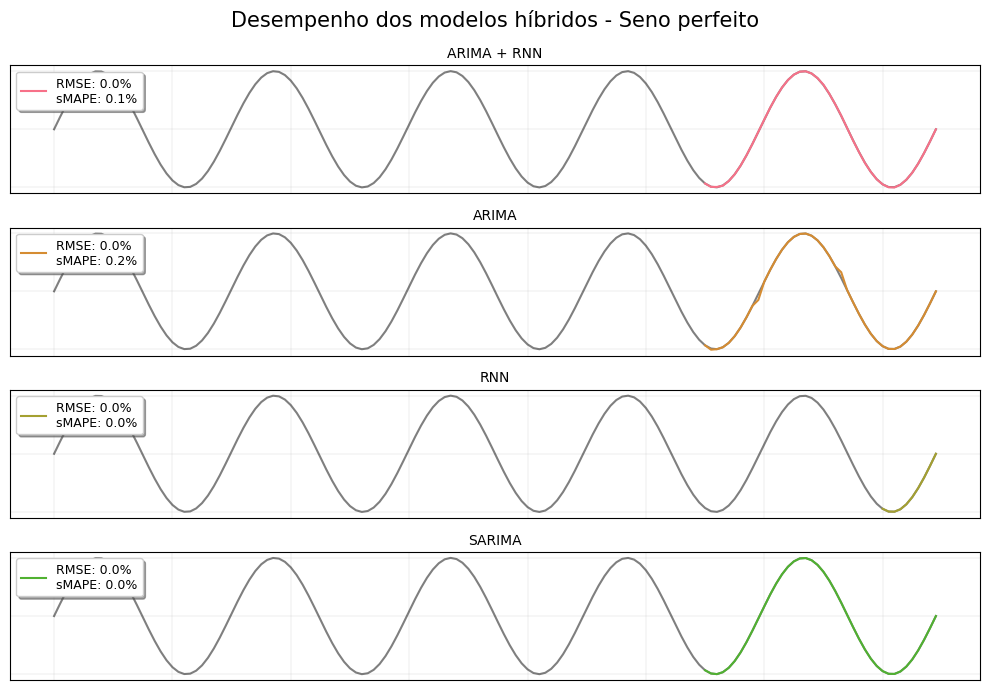

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7))

for i, model in enumerate(model_names):

    aux_data = preds_table.loc[(preds_table['Modelo'] == model) &
                               (preds_table['Conjunto de dados'] ==
                                dict_dataset_names[dataset_name]), :]
    aux_pred = aux_data['Predições'].values[0]
    aux_model = ' + '.join(model.split('_')).upper()

    axs[i].set_title(aux_model, fontsize=10)
    axs[i].plot(range(len(series)), series, color='black', alpha=0.5)
    axs[i].plot(range(len(series) - len(aux_pred), len(series)),
                aux_pred,
                color=color_palette[i],
                label="RMSE: {:.1f}%\nsMAPE: {:.1f}%".format(
                    aux_data['RMSE'].values[0], aux_data['sMAPE'].values[0]))

# plt.title("{} - Modelo {}".format(dict_dataset_names[dataset_name], aux_model),
#           fontsize=14)

for ax in axs:

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.legend(fontsize=9, shadow=True, loc='upper left')
    ax.grid(linewidth=0.15)

fig.suptitle("Desempenho dos modelos híbridos - {}".format(
    dict_dataset_names[dataset_name]),
             fontsize=15)
plt.tight_layout()
# plt.savefig("air_passengers.jpg", dpi=600)
plt.show()